In [132]:
import os
import gzip
import json
import subprocess
import itertools
import matplotlib.pyplot as plt  # type: ignore
import pandas as pd
import numpy as np
from scipy.stats import gmean, mannwhitneyu
import seaborn as sns

In [76]:
dashboard = os.path.expanduser("~/code/mgs-pipeline/dashboard/")

with open(os.path.join(dashboard, "human_virus_sample_counts.json")) as inf:
    human_virus_sample_counts = json.load(inf)

with open(os.path.join(dashboard, "metadata_samples.json")) as inf:
    metadata_samples = json.load(inf)

with open(os.path.join(dashboard, "metadata_bioprojects.json")) as inf:
    metadata_bioprojects = json.load(inf)

with open(os.path.join(dashboard, "metadata_papers.json")) as inf:
    metadata_papers = json.load(inf)

with open(os.path.join(dashboard, "taxonomic_names.json")) as inf:
    taxonomic_names = json.load(inf)


studies = list(metadata_papers.keys())


target_taxa = {
    2731341: ("duplodnaviria", "DNA Viruses"),
    2732004: ("varidnaviria", "DNA Viruses"),
    2731342: ("monodnaviria", "DNA Viruses"),
    2842242: ("ribozyviria", "RNA Viruses"),
    687329: ("anelloviridae", "DNA Viruses"),
    2559587: ("riboviria", "RNA Viruses"),
}


plotting_data = []
for study in studies:
    # Dropping studies that aren't WTP based
    if study in [
        "Johnson 2023",  # unpublished data
        "Cui 2023",  # untreated undigested sludge
        "Wang 2022",  # COVID-19 hospital wastewater
        "Petersen 2015",  # air plane waste
        "Hendriksen 2019",  # man hole"
        "Moritz 2019",  # university wastewater
        "Wu 2020",  # lung sample
        "Fierer 2022",  # university campus
    ]:
        continue

    if (
        study == "McCall 2023"
    ):  # dropping as samples always include DNA and RNA sequencing
        continue

    sequencing_type = metadata_papers[study]["na_type"]

    for bioproject in metadata_papers[study]["projects"]:
        samples = metadata_bioprojects[bioproject]

        if study == "Bengtsson-Palme 2016":
            samples = [
                sample
                for sample in samples
                if metadata_samples[sample]["fine_location"].startswith(
                    "Inlet"
                )
            ]

        if study == "Ng 2019":
            samples = [
                sample
                for sample in samples
                if metadata_samples[sample]["fine_location"] == "Influent"
            ]
        for sample in samples:
            if metadata_samples[sample].get("enrichment") == "panel":
                continue

            if study == "Brumfield 2022":
                # only study where we have separate DNA and RNA sequencing samples
                sequencing_type = metadata_samples[sample]["na_type"]

            cladecounts = "%s.tsv.gz" % sample
            if not os.path.exists(f"../cladecounts/{cladecounts}"):
                subprocess.check_call(
                    [
                        "aws",
                        "s3",
                        "cp",
                        "s3://nao-mgs/%s/cladecounts/%s"
                        % (bioproject, cladecounts),
                        "cladecounts/",
                    ]
                )
            with gzip.open(f"../cladecounts/{cladecounts}") as inf:
                na_type_abundances = {
                    "DNA Viruses": 0,
                    "RNA Viruses": 0,
                }
                for line in inf:
                    (
                        line_taxid,
                        _,
                        _,
                        clade_assignments,
                        _,
                    ) = line.strip().split()
                    taxid = int(line_taxid)
                    clade_hits = int(clade_assignments)
                    if taxid in target_taxa:
                        nucleic_acid_type = target_taxa[taxid][1]
                        relative_abundance = (
                            clade_hits / metadata_samples[sample]["reads"]
                        )

                        na_type_abundances[
                            nucleic_acid_type
                        ] += relative_abundance

                plotting_data.append(
                    {
                        "study": study,
                        "sample": sample,
                        **na_type_abundances,
                        "sequencing_type": sequencing_type,
                    }
                )
df = pd.DataFrame(plotting_data)

In [86]:
print(df)

                     study       sample  DNA Viruses   RNA Viruses   
0     Bengtsson-Palme 2016   ERR1414237     0.000195  1.282916e-07  \
1     Bengtsson-Palme 2016   ERR1414238     0.000232  2.082728e-07   
2     Bengtsson-Palme 2016   ERR1414239     0.000157  3.383347e-07   
3     Bengtsson-Palme 2016   ERR1414240     0.000148  2.384811e-07   
4     Bengtsson-Palme 2016   ERR1414241     0.000151  5.762961e-08   
...                    ...          ...          ...           ...   
1726             Yang 2020  SRR12204847     0.000013  3.434274e-01   
1727             Yang 2020  SRR12204848     0.000011  3.165715e-02   
1728             Yang 2020  SRR12204849     0.000013  1.983512e-01   
1729             Yang 2020  SRR12204850     0.000024  3.145158e-01   
1730             Yang 2020  SRR12204851     0.000020  3.903069e-01   

     sequencing_type  
0                DNA  
1                DNA  
2                DNA  
3                DNA  
4                DNA  
...              ... 

In [148]:
df_plotting = df[(df.drop(["study", "sample"], axis=1) != 0).all(1)].melt(
    id_vars=["study", "sample", "sequencing_type"],
    value_vars=["DNA Viruses", "RNA Viruses"],
    var_name="virus_na_type",
    value_name="relative_abundance",
)

df_plotting["seq_na_virus_combo"] = (
    df_plotting["sequencing_type"]
    + " Sequencing / "
    + df_plotting["virus_na_type"]
)

seq_na_virus_combo_ordered = [
    "DNA Sequencing / DNA Viruses",
    "RNA Sequencing / DNA Viruses",
    "DNA Sequencing / RNA Viruses",
    "RNA Sequencing / RNA Viruses",
]

df_plotting["seq_na_virus_combo"] = pd.Categorical(
    df_plotting["seq_na_virus_combo"], categories=seq_na_virus_combo_ordered, ordered=True
)

df_plotting = df_plotting.sort_values("seq_na_virus_combo")

combinations = list(itertools.pairwise(seq_na_virus_combo_ordered))

p_values = []

for combination in combinations:

    _, p_value = mannwhitneyu(
            df_plotting[df_plotting["seq_na_virus_combo"] == combination[0]][
                "relative_abundance"
            ],
            df_plotting[df_plotting["seq_na_virus_combo"] == combination[1]][
                "relative_abundance"
            ],
        )
    p_values.append(p_value)
    print(
        f"p_value when comparing '{combination[0]}' and '{combination[1]}' = {p_value}"
    )



p_value when comparing 'DNA Sequencing / DNA Viruses' and 'RNA Sequencing / DNA Viruses' = 1.1060223286888321e-67
p_value when comparing 'RNA Sequencing / DNA Viruses' and 'DNA Sequencing / RNA Viruses' = 1.0522193558851559e-97
p_value when comparing 'DNA Sequencing / RNA Viruses' and 'RNA Sequencing / RNA Viruses' = 1.1150289937822445e-95


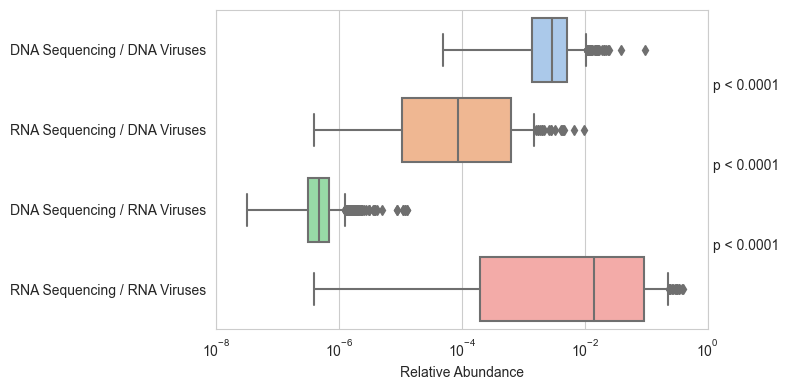

In [142]:
plt.figure(figsize=(8, 4))
sns.boxplot(x="relative_abundance", y="seq_na_virus_combo", data=df_plotting)
plt.xscale("log")
plt.xlabel("Relative Abundance")

plt.ylabel("")
ax = plt.gca()
ax.set_xlim(right=1, left=1e-8)


for i in range(0, 3):
    p_value = p_values[i] # pulling out the respective p_value
    ax.text(
        1.2,
        i + 0.5,
        
        f"p < {0.0001}" if p_value < 0.0001 else f"p = {round(p_value, 3)}",
 
    )


plt.tight_layout()
plt.savefig("supplement_1_figure.png", dpi=300, bbox_inches="tight")




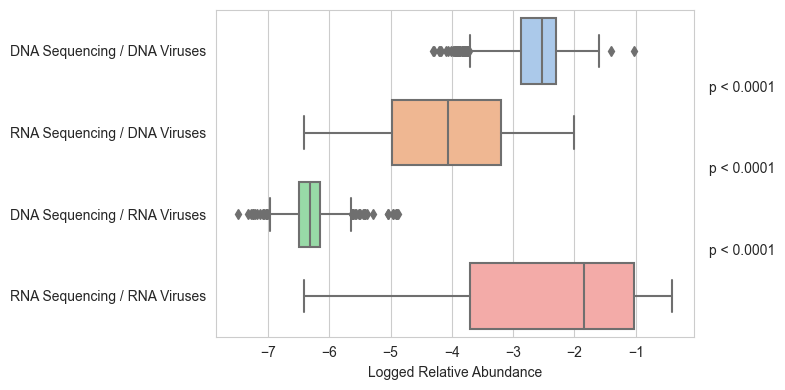

In [157]:
df_plotting['log_relative_abundance'] = np.log10(df_plotting['relative_abundance'])

plt.figure(figsize=(8, 4))
sns.boxplot(x="log_relative_abundance", y="seq_na_virus_combo", data=df_plotting)

plt.xlabel("Logged Relative Abundance")

plt.ylabel("")
ax = plt.gca()



for i in range(0, 3):
    p_value = p_values[i] # pulling out the respective p_value
    ax.text(
        0.2,
        i + 0.5,
        
        f"p < {0.0001}" if p_value < 0.0001 else f"p = {round(p_value, 3)}",
 
    )

plt.tight_layout()
